---
# 05 - Algorithms & Complexity
---

In [ ]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [ ]:
import expectexception

# Algorithms

We have learned a bit about how to program in Python and some ways in which we can make our code more Pythonic.  However, programming is not only about making the computer do work for us, its about optimizing the amount of work the computer needs to do.  There are multiple types of work we can consider, but here we will consider three major bottlenecks in code:

1. _Computational Complexity_ - how many instructions are executed?
2. _Memory Needs_ - how much memory is needed?
3. _I/O_ - How many reads and writes or network requests do I need to make?

An *Algorithm* is a procedure for solving a problem.  It describes a sequence of operations that when performed will result in a solution to a problem.  There are many types of algorithms, some are guaranteed to find a solution, some do not. Often we are interested in understanding the performance of an algorithm in terms of the three bottlenecks listed above (as well as others).  In order to analyze these algorithms, we need to develop some tools to understand how algorithms behave as a function of the problem size.

## Big O

In order to quantify the complexity of a particular algorithm, we can consider how the algorithm grows with respect to the size of the problem.  For the purposes of this notebook we will only consider problems that are one dimensional, so we can quantify the algorithm with respect to a single number, which we will denote as $N$.  Remember that a problem itself does not have a complexity, rather it is the algorithmic solution which has complexity.  For example, lets consider the problem of summing all the numbers between 1 and $N$ (inclusive).  On way to sum this might be to take all of these numbers.

In [ ]:
def sum_num(N):
    sum_ = 0
    for n in range(N + 1):
        sum_ += n
    return sum_

This algorithm will be $O(N)$ because we need to perform about $N$ operations.  Note that we only care about the dominant function of $N$ in the expansion so for our purposes $O(N) \approx O(N+1) \approx O(2N)$.

However, if we remember think a bit about how numbers sum, we can invoke a summation rule often attributed to Gauss which says that 
$$\sum_{n=1}^{N} n = \frac{N(N+1)}{2}$$

In [ ]:
def sum_gauss(N):
    return N*(N+1)//2 # We can use integer division here, why?

This algorithm is $O(1)$ because it does not depend on how the size of $N$!.  Lets just check that it gives the same answer.

In [ ]:
for N in range(100):
    assert sum_num(N) == sum_gauss(N)

Now lets plot the time it takes to compute these functions as a function of $N$.  We will use a package called `matplotlib` to do some plotting, don't worry, we will learn about it later!

We will time how long it takes to perform both of these algorithms.  We will take the mean of several runs.

In [ ]:
import matplotlib.pyplot as plt
import time

def compute(n_avgs, func, N):
    times = []
    for _ in range(n_avgs):
        ts = time.time()
        func(N)
        times.append(time.time() - ts)
    return sum(times)/float(len(times)) * 1000 # milliseconds

n_avgs = 100
time_sum = []
time_gauss = []
N_range = range(10,100000, 5000)
for N in N_range:
    time_sum.append(compute(n_avgs, sum_num, N))
    time_gauss.append(compute(n_avgs, sum_gauss, N))

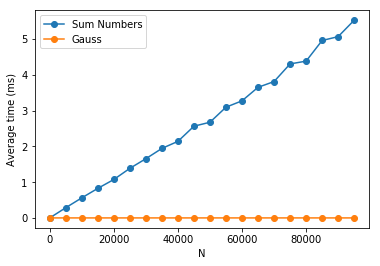

In [ ]:
plt.plot(N_range, time_sum, 'o-', label='Sum Numbers')
plt.plot(N_range, time_gauss, 'o-', label='Gauss')
plt.xlabel('N')
plt.ylabel('Average time (ms)')
plt.legend()

## Computational Complexity

Lets solve a version of a common problem you might find as a data scientist, how should I store my data?  Lets take a very simple case where our data is just a list of numbers and we need to store this in a list?  Is there any way to optimize the storage?

Lets consider the tradeoffs for various things we might want to do in the list.  

### Finding an element

If we want to find an element in a list and we know nothing about that list, then we need to check every element in the list to see if that element is there.  Let's write a function to do this.

In [ ]:
def find_ele(list_, ele):
    for i in list_:
        if i == ele:
            return True
    return False

In order to test these, lets use the `random` module to generate a list of random numbers between $0$ and $10 *N$ where $N$ is the length of the list we want.

In [ ]:
import random
def random_list(N, sort=False):
    list_ = [random.randint(0, 10*N) for _ in range(N)]
    return sorted(list_) if sort else list_

In [ ]:
random_list(5)

[27, 39, 34, 14, 33]

In [ ]:
import numpy as np

def time_func(func, *args):
    ts = time.time()
    func(*args)
    return time.time() - ts

def compute_with_list(n_avgs, N, sort, *funcs):
    ans = []
    for _ in range(n_avgs):
        list_r = random_list(N, sort)
        n_to_find = random.randint(0, 10*N)
        ans.append([time_func(func, list_r, n_to_find)
                for func in funcs])
    # now find avg
    return np.array(ans).mean(axis=0)*1000
    

n_avgs = 40
N_range = range(10, 100000, 10000)
time_list = np.array([compute_with_list(n_avgs, N, False, find_ele) for N in N_range])

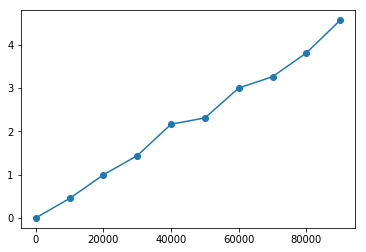

In [ ]:
plt.plot(N_range, time_list, 'o-')

Let us take a slightly different approach where we know that this list sorted.  Note that sorting itself is $N\log(N)$ complexity, so although we will be able to perform optimized searches on a sorted list, its not in general faster to sort and then find the elements.  However, if we know we will be searching often, we can build up the list as a sorted structure and for now we can assume that we have already done so.

The most basic optimization we can perform is to only check until we have seen a number greater than what we are looking for.  Since we know the list is sorted, we are guaranteed to not find the number in the rest of the list.

In [ ]:
def find_ele_sorted(list_, ele):
    for i in list_:
        if i == ele:
            return True
        if i > ele:
            return False
    return False

n_avgs = 40
N_range = range(10, 100000, 10000)
time_list = np.array([compute_with_list(n_avgs, N, True, find_ele, find_ele_sorted) for N in N_range])

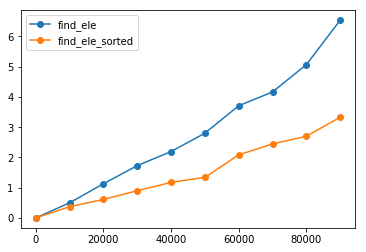

In [ ]:
plt.plot(N_range, time_list[:,0], 'o-', label='find_ele')
plt.plot(N_range, time_list[:,1], 'o-', label='find_ele_sorted')
plt.legend()

This does better on average, but it still has the same $O(N)$ runtime.  Such optimizations are useful, but we can do better.  Lets implement what is sometimes known as binary search.  This is a recursive algorithm that allows the list to be divided roughly in half on each recursive step.  this will yield logarithmic asymptotic run time.  Lets first illustrate the algorithm by walking through an example where `l_=[1,2,3,4,5,6,7,8,9,10,11]` and we want to check if 2 is contained in the list.

First we check the midpoint of the list, which is 6.  We know that 2 does not equal 6, but since the list is sorted, we can immediately rule out the part of the list containing numbers greater than 6.  Thus we have already ruled out half the elements of the list. 

Now we can ask the question is 2 contained in list `[1,2,3,4,5]`.  First we check the midpoint element of the list, which is 3.  We know that 3 does not equal 2, but again, since $3>2$, we can eliminate half the list.

Now we can check if 2 is contained in the list `[1,2]`.  We will take midpoint of this list as the first element (since it has index $1=len(list)/2$), and this is equal to 2.  Thus 2 is in the original list.

We can see we have performed this search in only three steps and up to an extra step, this did not depend on where 2 was in the list, only that it was sorted.  Since we are removing half the list each time, we expect that the number of steps will be roughly $log(N)$, where the logarithm is understood to be base 2.  Lets make a plot of this function compared to $N$.

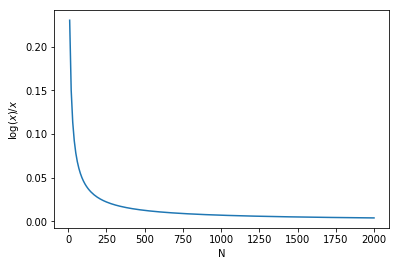

In [ ]:
x = np.linspace(10, 2000, 200)
plt.plot(x, np.log(x)/x)
plt.xlabel('N')
plt.ylabel(r'$\log(x)/x$')

Now we can compare this to our other search algorithms.

In [ ]:
def find_ele_binary(l_, ele):
    if len(l_) < 1:
        return False
    mid_point = len(l_)//2
    if l_[mid_point] == ele:
        return True
    elif l_[mid_point] > ele:
        return find_ele_binary(l_[:mid_point], ele)
    else:
        return find_ele_binary(l_[mid_point+1:], ele)

In [ ]:
n_avgs = 50
N_range = np.arange(1000, 70000, 8000)
time_list = np.array([compute_with_list(n_avgs, N, True, find_ele_sorted, find_ele_binary) for N in N_range])

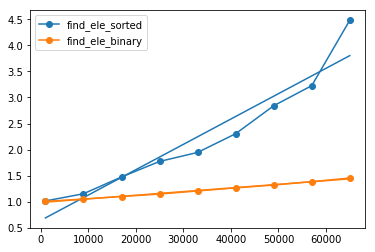

In [ ]:
for i, func in enumerate(['find_ele_sorted', 'find_ele_binary']):
    l, = plt.plot(N_range, 2**time_list[:, i], 'o-', label=func)
    # fit a line to the exponent
    p = np.polyfit(N_range, 2**time_list[:, i], 1)
    plt.plot(N_range, N_range * p[0] + p[1], color=l.get_color())

plt.legend()

Of course, if we are only keeping track of what numbers we have seen, we can use something like a `set` which will be $O(1)$ access.

## Memoization

Often we can get a performance increase just by not recomputing things we have already computed!  Let's look again at our recursive Fibonacci sequence defined in a previous notebook.

In [ ]:
def fibonacci_recursive(n):
    if n == 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci_recursive(n-1)  + fibonacci_recursive(n-2)

Lets make a slightly different version which keeps track of how many times we call the function on each element.

In [ ]:
from collections import defaultdict
def fibonacci_count(n, d):
    d[n] += 1
    if n == 0:
        return 0, d
    elif n == 1:
        return 1, d
    else:
        n1, _ = fibonacci_count(n-1, d)
        n2, _ = fibonacci_count(n-2, d)
        return n1 + n2, d

Lets see this in action for $N=5$. 

In [ ]:
N = 5
ans, d = fibonacci_count(N, defaultdict(int))
for i in range(N):
    print(i, d[i])

0 3
1 5
2 3
3 2
4 1



              5
          4       3
         3 2     2 1
       2 1 1 0  1 0
      1 0

Now lets look for $N=25$.

In [ ]:
N = 25
ans, d = fibonacci_count(N, defaultdict(int))
print(ans)
for i in range(N):
    print(i, d[i])

75025
0 46368
1 75025
2 46368
3 28657
4 17711
5 10946
6 6765
7 4181
8 2584
9 1597
10 987
11 610
12 377
13 233
14 144
15 89
16 55
17 34
18 21
19 13
20 8
21 5
22 3
23 2
24 1


Notice that we are calling some of these functions with the same argument thousands of time.  If we store the answer to the problem instead of recomputing it, can we do any better?

In [ ]:
def fibonacci_mem(n, d):
    if n in d:
        return d[n]
    elif n == 0:
        ans = 0
    elif n == 1:
        ans = 1
    else:
        ans = fibonacci_mem(n-1, d) + fibonacci_mem(n-2, d)
    d[n] = ans
    return ans

In [ ]:
%%timeit
fibonacci_mem(33, {0:0,1:1})

14.9 µs ± 223 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
%%timeit
fibonacci_recursive(33)

1.68 s ± 9.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
fibonacci_mem(33, {}) == fibonacci_recursive(33)

True

Our memoized solution does much better, it is several orders of magnitude faster than the bare recursive solution.  

However, it does come at a cost, although we save computation, we must use more memory to store the previous result.  Often there will be a tradeoff between the two.

### Exercise

1. Write the factorial function $f(n) = n!$ as a recursive function.
2. Would memoization make this function faster?
3. Now what if we needed to calculate the factorial often (perhaps we were computing probabilities of different selections), could we use memoization in this case?

Ex 1. Write the factorial function $f(n) = n!$ as a recursive function

In [1]:
def factorial_recursive(n):
    if n == 1 or n == 0:
        return 1
    else:
        return n*factorial_recursive(n-1)

In [2]:
factorial_recursive(1)

1

In [3]:
factorial_recursive(2)

2

In [4]:
factorial_recursive(3)

6

In [5]:
factorial_recursive(4)

24

In [6]:
factorial_recursive(5)

120

In [7]:
import math

In [8]:
for n in range(1000):
    assert factorial_recursive(n) == math.factorial(n)

RecursionError: ignored

Ex 2. Would memoization make this function faster?

**Answer:** No! Because we do not have intermediate results which are used by subsequent results of our computations

3. Now what if we needed to calculate the factorial often (perhaps we were computing probabilities of different selections), could we use memoization in this case?

**Answer:** If we needed to calculate the factorial often repeatedly and storing to use their probabilities later, we will definitely need memoization

## Memory
As seen before memoization has a tradeoff in terms of memory.  Lets try to describe that here for the case of the Fibonacci sequence.  We have to keep track of a single element number (the computed solution) for all number less than $N$, the number we want to compute.  Thus the memory we need grows with problem size as $O(N)$.

We can analyze our algorithms in terms of memory in a similar way.  Again remember, it is the algorithm (and its implementation) which has memory complexity, not the problem itself.  

For our first problem, we will again look at summing the numbers between 0 and $N$, and we will take two different approaches.

For the first we will build a list of these elements and then sum them.

In [ ]:
def sum_list(n):
    numbers = list(range(n))
    return sum(numbers)

In [ ]:
def sum_iter(n):
    number = 0
    sum_ = 0
    while number < n:
        sum_ += number
        number += 1
    return sum_

In [ ]:
sum_list(100), sum_iter(100)

(4950, 4950)

## Choose a data structure wisely

As we may have noticed in the sorting section, the type of data structure we use is often tied into our choice of algorithm.  For example, if we don't already have sorted data, we probably don't want to use binary search because we would need to sort the data first and then would negate any search improvement (sorting is worse than $O(N)$).  

This can be mitigated by choosing our original structure wisely, especially when get to build it from raw data.  For example when building a list, inserting elements in a sorted manner can be done in $O(log(N))$ time (with almost the same as binary search).  

Other data structures lend themselves to other algorithmic purposes..  For example, a `heap` (implemented in Python with the [`heapq`](https://docs.python.org/2/library/heapq.html) library) implements a tree like structure which is useful for order statistics, such as keeping track of the largest or smallest $N$ items in a collection.  You can read more about it [here](https://en.wikipedia.org/wiki/Binary_heap).

Even as you work through your miniprojects, sometimes choosing a dictionary instead of a list will be the difference between minutes or seconds of computation.

### Exercises

1. Explain why sorting and then using binary search is slower than just searching.
2. Implement insertion on a list using the same principles as binary search.

Ex 1. Explain why sorting and then using binary search is slower than just searching.

**Answer:** Sorting and searching requires storage and searching leading to more read/writes than with just searching

Ex 2. Implement insertion on a list using the same principles as binary search.

*Copyright &copy; 2018 The Data Incubator.  All rights reserved.*